In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import shutil
import time
import copy

import tqdm


In [3]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

In [79]:
train_df.head()

Image_id  Label
0  id_02amazy34fgh2.jpg      1
1  id_02mh3w48pmyc9.jpg      0
2  id_02rpb463h9d3w.jpg      0
3  id_02wc3jeeao8ol.jpg      1
4  id_03t2hapb8wz8p.jpg      1

In [76]:
# !mkdir train_images

In [77]:
# !mkdir train_images/0
# !mkdir train_images/1

In [88]:
# !mkdir val_images
# !mkdir val_images/0
# !mkdir val_images/1

In [83]:
# X_train, X_val, y_train, y_val = train_test_split(np.array(train_df.drop("Label", axis=1)), np.array(train_df["Label"]), test_size=0.3, shuffle=True)

In [90]:
# for img, label in zip(X_train, y_train):
#     source_path = "images/" + img.item()
#     dest_path = "train_images/" + str(label)
#     shutil.copy(source_path, dest_path)

In [91]:
# for img, label in zip(X_val, y_val):
#     source_path = "images/" + img.item()
#     dest_path = "val_images/" + str(label)
#     shutil.copy(source_path, dest_path)

In [2]:
import torch
import torchvision

In [4]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(255),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomGrayscale(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(255),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder("train_images/", train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder("val_images/", val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

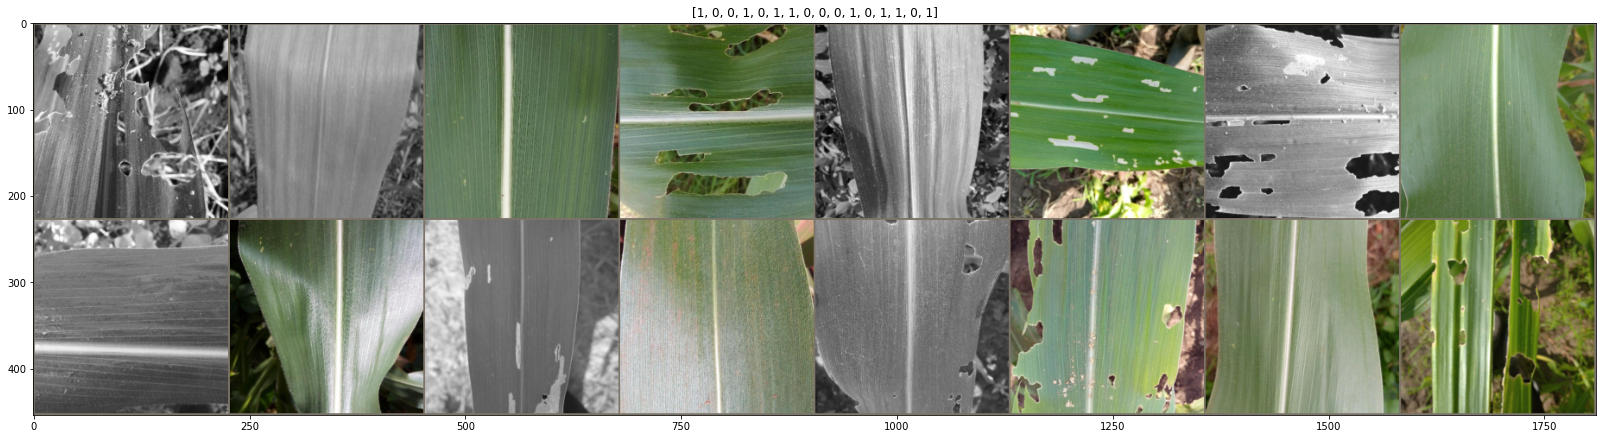

In [6]:
def show_batch(img, title=None):
    plt.figure(figsize=(28, 10))
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = mean + img * std
    img = np.clip(img, 0, 1)    
    if title is not None:
        plt.title(title)
    plt.imshow(img)

inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

show_batch(out, title=[x.item() for x in classes])

In [97]:
dataloader = {
    "train": train_dataloader,
    "val": val_dataloader 
}

datasize = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(DEVICE)

cuda


In [55]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [105]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_top5 = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            running_top5 = 0
            

            with tqdm.tqdm(dataloader[phase], unit="batch") as bar:
                for inputs, labels in bar:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    # Zero the parametsrs
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                        
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    
                    bar.set_postfix(loss=loss.item())
                
                if phase == "train":
                    scheduler.step()
                
                epoch_loss = running_loss / datasize[phase]
                epoch_acc = running_corrects.double()/datasize[phase]
                
                print()
                print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                if(phase == "val" and epoch_acc > best_acc):
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f \n".format(best_acc))
    
    # load best model parameters
    return model

In [106]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=5)

Epoch 0/4
----------


100%|██████████| 71/71 [00:48<00:00,  1.46batch/s, loss=0.149]   



train Loss: 0.0192 Acc: 0.9947


100%|██████████| 31/31 [00:16<00:00,  1.86batch/s, loss=0.00522] 



val Loss: 0.0030 Acc: 1.0000

Epoch 1/4
----------


100%|██████████| 71/71 [00:48<00:00,  1.47batch/s, loss=0.0849]  



train Loss: 0.0229 Acc: 0.9894


100%|██████████| 31/31 [00:15<00:00,  1.99batch/s, loss=0.00383] 



val Loss: 0.0039 Acc: 1.0000

Epoch 2/4
----------


100%|██████████| 71/71 [00:46<00:00,  1.53batch/s, loss=0.195]   



train Loss: 0.0255 Acc: 0.9912


100%|██████████| 31/31 [00:14<00:00,  2.12batch/s, loss=0.00277] 



val Loss: 0.0050 Acc: 0.9979

Epoch 3/4
----------


100%|██████████| 71/71 [00:46<00:00,  1.54batch/s, loss=0.0158]  



train Loss: 0.0221 Acc: 0.9921


100%|██████████| 31/31 [00:14<00:00,  2.11batch/s, loss=0.00394] 



val Loss: 0.0033 Acc: 1.0000

Epoch 4/4
----------


100%|██████████| 71/71 [00:48<00:00,  1.45batch/s, loss=0.00117] 



train Loss: 0.0155 Acc: 0.9947


100%|██████████| 31/31 [00:15<00:00,  2.02batch/s, loss=0.00474] 



val Loss: 0.0033 Acc: 1.0000

Training complete in 5.000000m 14.902343s
Best val Acc: 1.0:4f 



In [112]:
# !mkdir test_images/
# !mkdir test_images/test

In [113]:
# for img in test_df["Image_id"]:
#     source_path = "images/" + img
#     dest_path = "test_images/test"
#     shutil.copy(source_path, dest_path)

In [124]:
torch.save(model_ft, "model.pt")

In [8]:
test_dataset = torchvision.datasets.ImageFolder("test_images/", val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=False)

In [9]:
preds = []

model_ft = torch.load("model.pt").to(DEVICE)

In [10]:
for images, labels in test_dataloader:
    preds.append(model_ft(images.to(DEVICE)))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.28 GiB already allocated; 8.69 MiB free; 1.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF